In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib.pylab import rcParams
from datetime import datetime
rcParams['figure.figsize'] = 10, 6

In [3]:
dataset = pd.read_csv('Users.csv', encoding='utf-16', sep = '\t')
dataset = dataset.iloc[:, 2:4]
dataset['Date'] = pd.to_datetime(dataset['Date'], infer_datetime_format = True)
indexedDataset = dataset.set_index(['Date'])

In [4]:
#dataset['Date']
indexedDataset.tail()

,# Distinct Users
Date,
2020-06-01,24625
2020-07-01,23621
2020-08-01,23750
2020-09-01,25300
2020-10-01,26204


C:\Users\q1011812\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\plotting\_matplotlib\converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


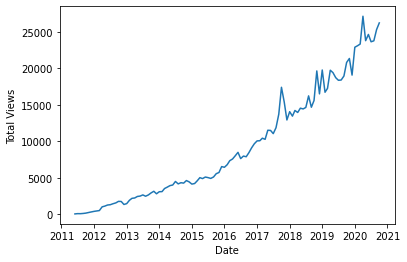

In [5]:
plt.xlabel('Date')
plt.ylabel('Total Views')
plt.plot(indexedDataset)

In [6]:
# Find the rolling statistics
rollingMean = indexedDataset.rolling(window = 12).mean()

rollingSTD = indexedDataset.rolling(window = 12).std()
print(rollingMean, rollingSTD)

            # Distinct Users
Date                        
2011-06-01               NaN
2011-07-01               NaN
2011-08-01               NaN
2011-09-01               NaN
2011-10-01               NaN
...                      ...
2020-06-01      21801.666667
2020-07-01      22241.250000
2020-08-01      22688.666667
2020-09-01      23219.166667
2020-10-01      23670.583333

[113 rows x 1 columns]             # Distinct Users
Date                        
2011-06-01               NaN
2011-07-01               NaN
2011-08-01               NaN
2011-09-01               NaN
2011-10-01               NaN
...                      ...
2020-06-01       2793.515001
2020-07-01       2609.258450
2020-08-01       2332.831730
2020-09-01       2115.043943
2020-10-01       2126.798510

[113 rows x 1 columns]


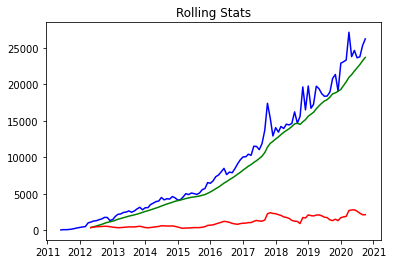

In [7]:
# Plot Rolling Stats

orig = plt.plot(indexedDataset, color = 'blue', label='Original')
mean = plt.plot(rollingMean, color = 'green', label='Rolling Mean')
std = plt.plot(rollingSTD, color='red', label='Rolling STD')
plt.title('Rolling Stats')
plt.show(block=False)

In [9]:
# Perform Dickey-Fuller Test
from statsmodels.tsa.stattools import adfuller

print('Results of Dickey-Fuller Test:')
dftest = adfuller(indexedDataset['# Distinct Users'], autolag = 'AIC')

dfoutput = pd.Series(dftest[0:4], index = ['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
for key,value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
    
print(dfoutput)

Results of Dickey-Fuller Test:
Test Statistic                   3.974422
p-value                          1.000000
#Lags Used                      11.000000
Number of Observations Used    101.000000
Critical Value (1%)             -3.496818
Critical Value (5%)             -2.890611
Critical Value (10%)            -2.582277
dtype: float64


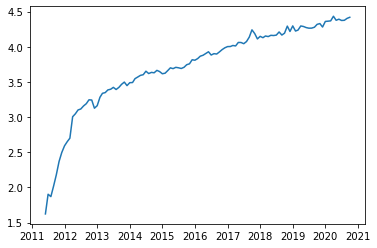

In [10]:
# Estimate the trend
indexedDataset_logScale = np.log10(indexedDataset)
plt.plot(indexedDataset_logScale)

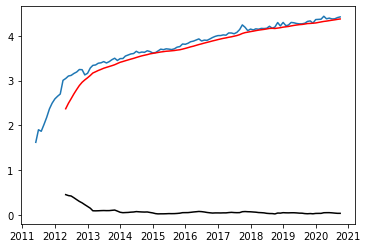

In [11]:
movingAverage = indexedDataset_logScale.rolling(window = 12).mean()
movingSTD = indexedDataset_logScale.rolling(window = 12).std()
plt.plot(indexedDataset_logScale)
plt.plot(movingAverage, color='red')
plt.plot(movingSTD, color = 'black')

In [12]:
def test_stationary(timeseries):
    movingAverage = timeseries.rolling(window = 12).mean()
    movingSTD = timeseries.rolling(window = 12).std()
    
    #plot rolling stats:
    
    orig = plt.plot(timeseries, color = 'blue', label='Original')
    mean = plt.plot(movingAverage, color = 'green', label='Rolling Mean')
    std = plt.plot(movingSTD, color='red', label='Rolling STD')
    plt.title('Rolling Stats')
    plt.show(block=False)
    
    #Perform Dickey-Fuller test:
    
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries['# Analytics Viewed'], autolag = 'AIC')

    dfoutput = pd.Series(dftest[0:4], index = ['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value

    print(dfoutput)

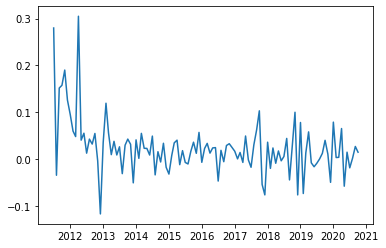

In [13]:
datasetLDShifting = indexedDataset_logScale - indexedDataset_logScale.shift()
plt.plot(datasetLDShifting)

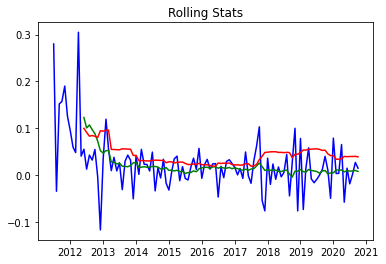

Results of Dickey-Fuller Test:


KeyError: '# Analytics Viewed'

In [14]:
datasetLDShifting.dropna(inplace = True)
test_stationary(datasetLDShifting)

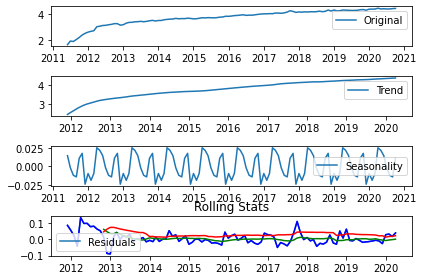

Results of Dickey-Fuller Test:


KeyError: '# Analytics Viewed'

In [15]:
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(indexedDataset_logScale)

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)
plt.plot(indexedDataset_logScale, label = 'Original')
plt.legend(loc = 'best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal, label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

decomposedLogData = residual
decomposedLogData.dropna(inplace=True)
test_stationary(decomposedLogData)

C:\Users\q1011812\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\q1011812\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Plotting AR Model


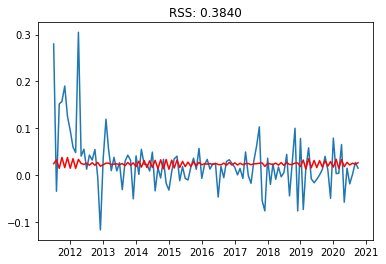

In [17]:
from statsmodels.tsa.arima_model import ARIMA

#AR Model
model = ARIMA(indexedDataset_logScale, order=(2,1,2))
results_AR = model.fit(disp = -1)
plt.plot(datasetLDShifting)
plt.plot(results_AR.fittedvalues, color='red')
plt.title('RSS: %.4f' % sum((results_AR.fittedvalues-datasetLDShifting['# Distinct Users'])**2))
print('Plotting AR Model')

C:\Users\q1011812\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\q1011812\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Plotting MA Model


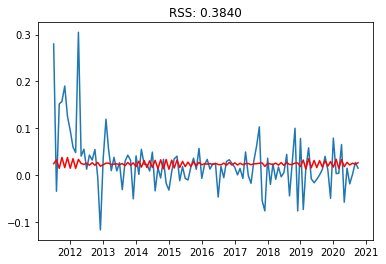

In [18]:
#MA Model
model = ARIMA(indexedDataset_logScale, order=(2,1,2))
results_MA = model.fit(disp = -1)
plt.plot(datasetLDShifting)
plt.plot(results_MA.fittedvalues, color='red')
plt.title('RSS: %.4f' % sum((results_MA.fittedvalues-datasetLDShifting['# Distinct Users'])**2))
print('Plotting MA Model')

C:\Users\q1011812\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\q1011812\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Plotting ARIMA Model


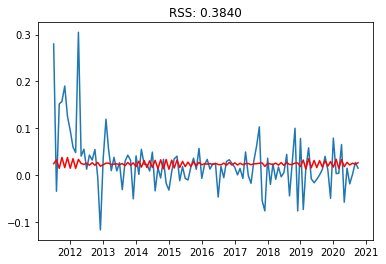

In [19]:
model = ARIMA(indexedDataset_logScale, order=(2,1,2))
results_ARIMA = model.fit(disp = -1)
plt.plot(datasetLDShifting)
plt.plot(results_AR.fittedvalues, color='red')
plt.title('RSS: %.4f' % sum((results_ARIMA.fittedvalues-datasetLDShifting['# Distinct Users'])**2))
print('Plotting ARIMA Model')

In [20]:
predictions_ARIMA_diff = pd.Series(results_ARIMA.fittedvalues, copy=True)
print(predictions_ARIMA_diff.head())

Date
2011-07-01    0.024981
2011-08-01    0.033002
2011-09-01    0.015079
2011-10-01    0.038229
2011-11-01    0.016451
dtype: float64


In [21]:
#Convert to cummulative sum
preductions_ARIMA_diff_cumsum = predictions_ARIMA_diff.cumsum()
print(preductions_ARIMA_diff_cumsum.head())

Date
2011-07-01    0.024981
2011-08-01    0.057983
2011-09-01    0.073062
2011-10-01    0.111290
2011-11-01    0.127741
dtype: float64


In [23]:
predictions_ARIMA_log = pd.Series(indexedDataset_logScale['# Distinct Users'].ix[0], index=indexedDataset_logScale.index)
predictions_ARIMA_log = predictions_ARIMA_log.add(preductions_ARIMA_diff_cumsum, fill_value=0)
predictions_ARIMA_log.head()

C:\Users\q1011812\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#ix-indexer-is-deprecated
  """Entry point for launching an IPython kernel.


Date
2011-06-01    1.623249
2011-07-01    1.648230
2011-08-01    1.681232
2011-09-01    1.696311
2011-10-01    1.734540
dtype: float64

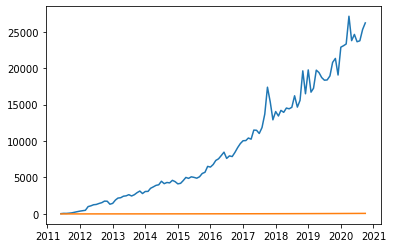

In [24]:
predictions_ARIMA= np.exp(predictions_ARIMA_log)
plt.plot(indexedDataset)
plt.plot(predictions_ARIMA)

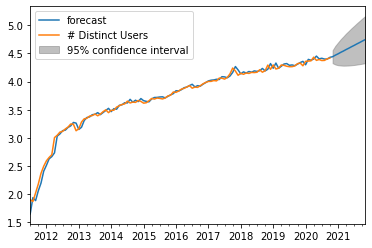

In [25]:
#indexedDataset_logScale.head() - 113rows
results_ARIMA.plot_predict(1, 125)
x=results_ARIMA.forecast(steps=12)

In [26]:
results_ARIMA.forecast(steps = 120)

(array([4.4413105 , 4.46836169, 4.49167501, 4.51838846, 4.54200828,
        4.56844216, 4.59231558, 4.618518  , 4.64260125, 4.66861204,
        4.69286889, 4.71872101, 4.74312147, 4.76884221, 4.79336146,
        4.8189734 , 4.8435909 , 4.86911272, 4.89381148, 4.91925865,
        4.94402459, 4.96940992, 4.9942314 , 5.01956548, 5.04443287,
        5.06972447, 5.09462978, 5.11988616, 5.1448228 , 5.17004996,
        5.19501247, 5.22021539, 5.24519924, 5.27038203, 5.29538348,
        5.32054956, 5.34556551, 5.37071769, 5.39574559, 5.42088619,
        5.44592391, 5.47105489, 5.49610067, 5.52122361, 5.54627601,
        5.57139223, 5.59645005, 5.62156066, 5.64662289, 5.67172879,
        5.69679462, 5.72189655, 5.7469653 , 5.7720639 , 5.797135  ,
        5.82223077, 5.84730376, 5.87239713, 5.89747162, 5.92256296,
        5.94763862, 5.97272821, 5.9978048 , 6.02289287, 6.04797016,
        6.07305692, 6.09813473, 6.12322035, 6.14829853, 6.17338315,
        6.19846158, 6.22354531, 6.24862388, 6.27

In [27]:
results = results_ARIMA.forecast(steps = 12)
res=[]
for r in results:
    res.append(10**r)

In [28]:
print(res[0])

[27625.52258429 29400.97183105 31022.37231502 32990.46707048
 34834.39584161 37020.48976903 39112.50063583 41544.92719043
 43913.82361912 46624.26969687 49302.49409736 52326.41880556]
